In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,optimizers,losses
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16


In [2]:
!pip install scikit-learn


In [3]:
import tensorflow as tf
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))


Num GPUs: 1


In [4]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

SET ALL THE CONSTANTS


In [5]:
BATCH_SIZE=32
IMAGE_SIZE=224
CHANNELS=3
EPOCHS=50

In [6]:
import os
from collections import Counter

data_dir = 'Images'  # your root directory
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            file for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        ])
        class_counts[class_name] = count

# Print counts
for cls, count in class_counts.items():
    print(f"Class: {cls}, Image Count: {count}")


Class: Blister_Blide, Image Count: 1170
Class: Brown_Blight, Image Count: 430
Class: healthy, Image Count: 74


In [7]:
datasets=tf.keras.preprocessing.image_dataset_from_directory(
    'Images',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

Found 1674 files belonging to 3 classes.


In [8]:

for image,image_labels in datasets.take(1):
    print(np.array(image).astype("uint8"))
    print(image_labels.numpy())

[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0

In [9]:
class_names=datasets.class_names
print(class_names)

['Blister_Blide', 'Brown_Blight', 'healthy']


Visualize some of Images

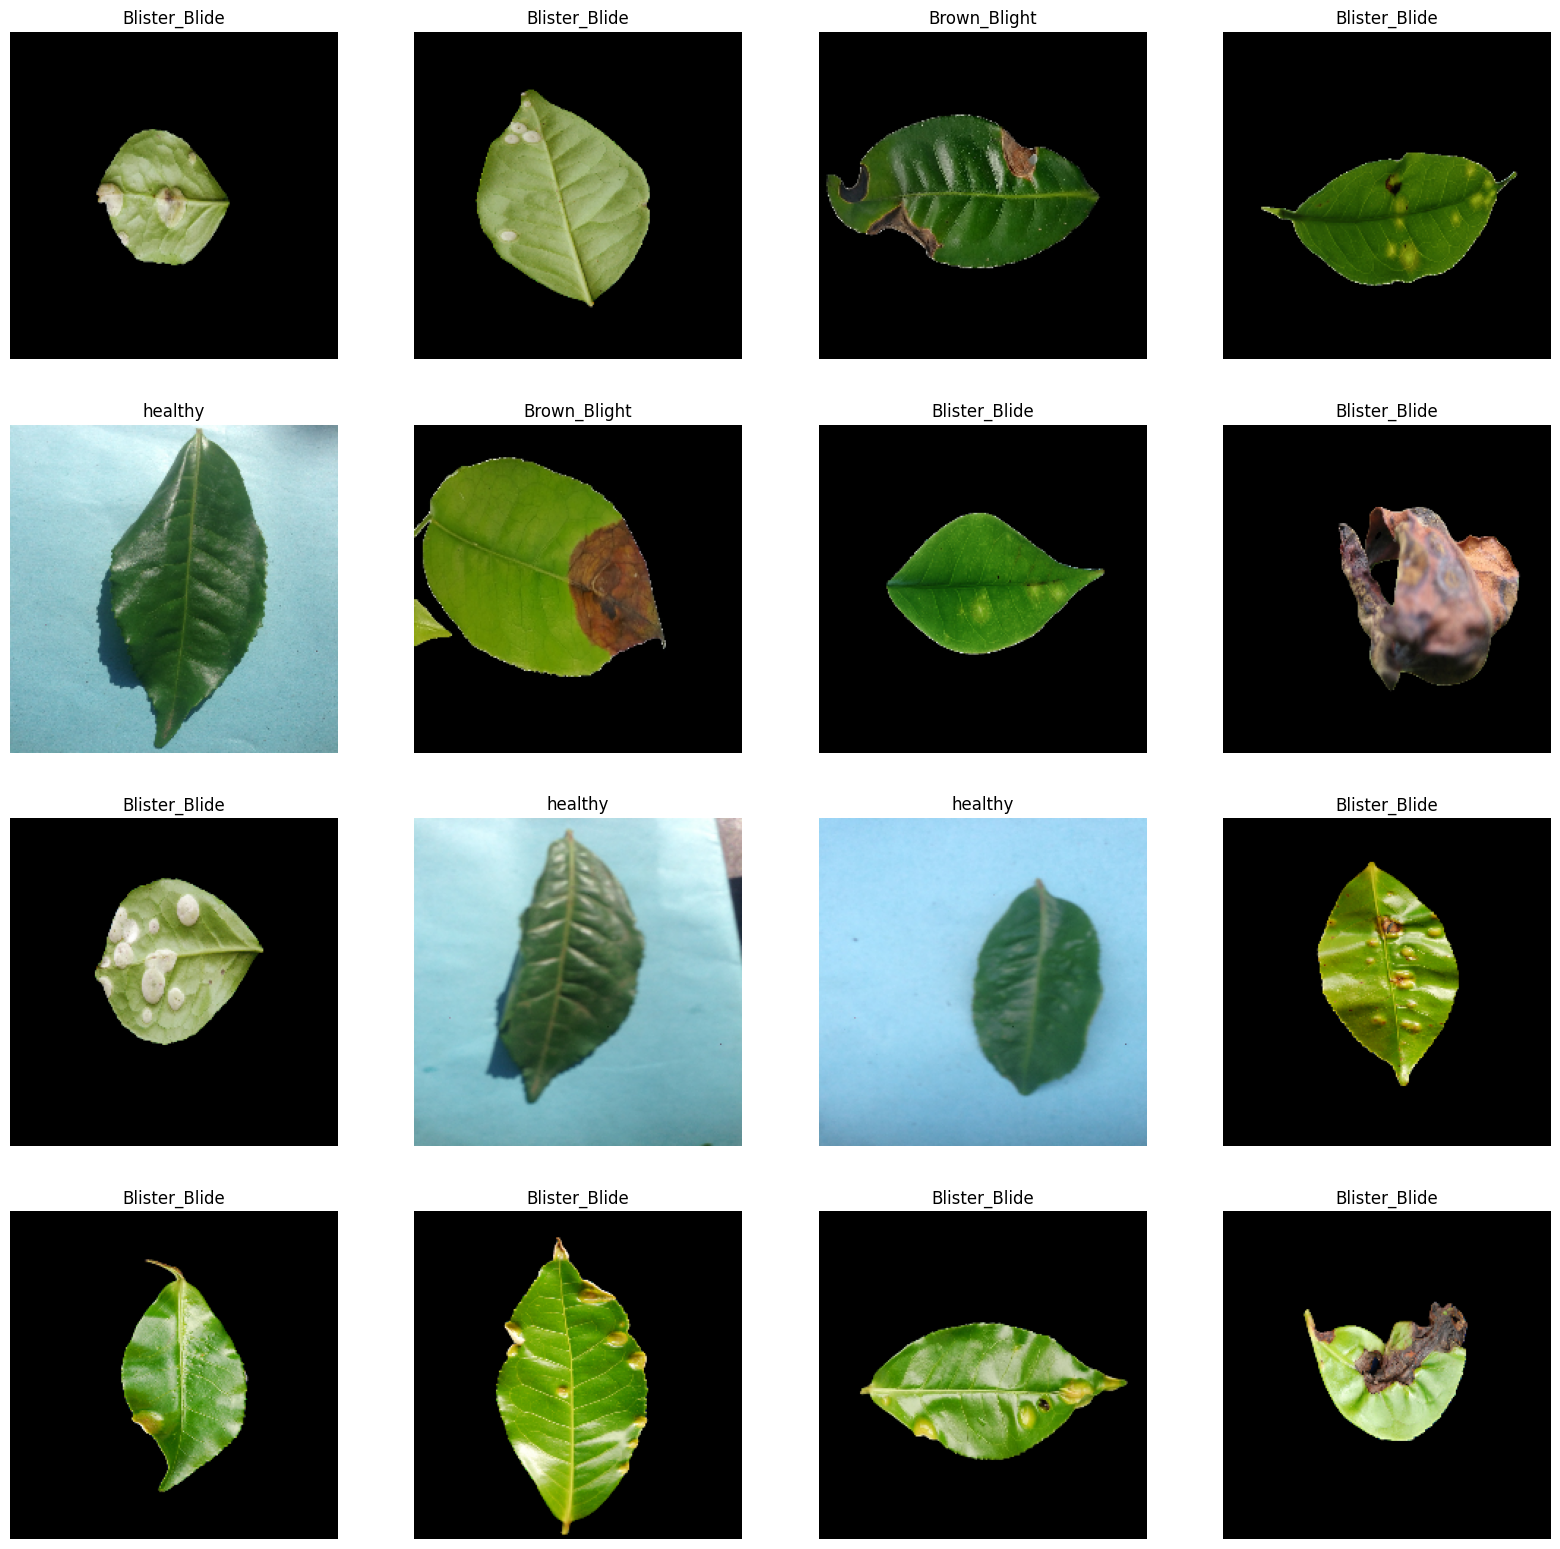

In [10]:
plt.figure(figsize=(20,40))

for image,image_labels in datasets.take(1):
    for i in range(16):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(class_names[image_labels[i].numpy()])
        plt.axis('off')

   

Split Function

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
   
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size+val_size)

    return train_ds,val_ds,test_ds

In [12]:
print(len(datasets))
Train_ds,Val_ds,Test_ds=get_dataset_partitions_tf(datasets)
print(len(Val_ds))

53
5


Building the Model

DATA Argumentation and Resizing


In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])


Train_ds = Train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
resize_and_rescale=models.Sequential([

    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)

])

Add Class Weights

In [15]:
from sklearn.utils import class_weight
import numpy as np

# Get all labels from the dataset
all_labels = []
for _, labels in datasets:
    all_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.47692307692307695, 1: 1.2976744186046512, 2: 7.54054054054054}


In [16]:
#Model build

input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)



model=models.Sequential([
    resize_and_rescale,
    base_model,
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')




])
model.build(input_shape=input_shape)


In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (32, 25088)               0         
                                                                 
 dense (Dense)               (32, 64)                  1605696   
                                                                 
 dense_1 (Dense)             (32, 3)                   195       
                                                                 
Total params: 16,320,579
Trainable params: 1,605,891
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
   
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='accuracy',      
    patience=10,              
    restore_best_weights=True,  
    mode='max',           
    verbose=1
)

history = model.fit(
    Train_ds,
    epochs=100,
    validation_data=Val_ds,  
    class_weight=class_weight_dict,
    callbacks=[early_stop]  
)


Epoch 1/100
42/42 [==============================] - 34s 387ms/step - loss: 0.8317 - accuracy: 0.6830 - val_loss: 0.2696 - val_accuracy: 0.8687
Epoch 2/100
42/42 [==============================] - 24s 528ms/step - loss: 0.1633 - accuracy: 0.9085 - val_loss: 0.2323 - val_accuracy: 0.9062
Epoch 3/100
42/42 [==============================] - 39s 873ms/step - loss: 0.1246 - accuracy: 0.9297 - val_loss: 0.1307 - val_accuracy: 0.9500
Epoch 4/100
42/42 [==============================] - 27s 525ms/step - loss: 0.1269 - accuracy: 0.9308 - val_loss: 0.1266 - val_accuracy: 0.9563
Epoch 5/100
42/42 [==============================] - 30s 545ms/step - loss: 0.0741 - accuracy: 0.9637 - val_loss: 0.0684 - val_accuracy: 0.9812
Epoch 6/100
42/42 [==============================] - 32s 608ms/step - loss: 0.0669 - accuracy: 0.9650 - val_loss: 0.0836 - val_accuracy: 0.9750
Epoch 7/100
42/42 [==============================] - 34s 617ms/step - loss: 0.0441 - accuracy: 0.9849 - val_loss: 0.0942 - val_accuracy:

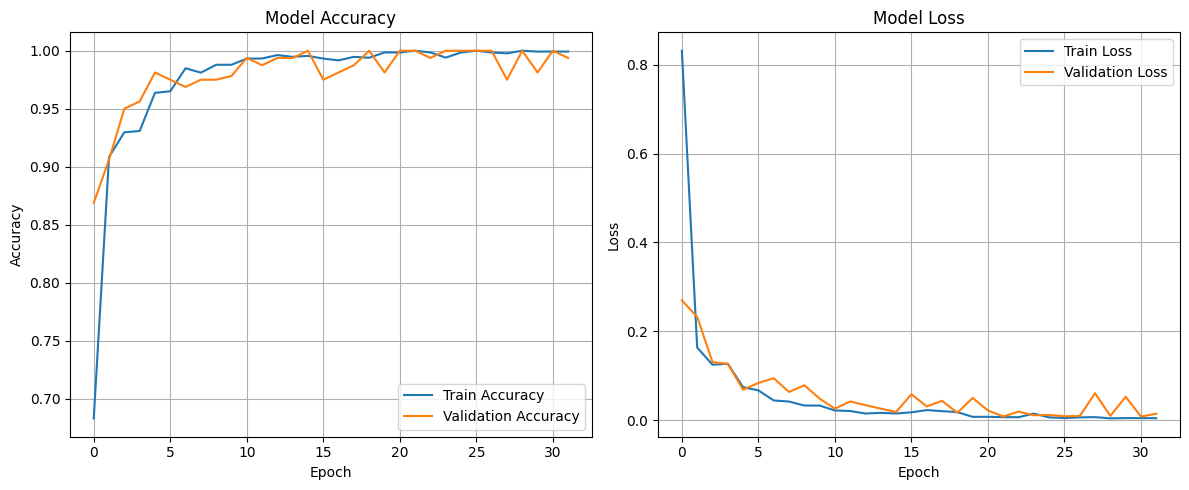

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    confidence = round(100 * (np.max(predictions[0])), 2)

    if( np.argmax(predictions[0]) == 0):
        predicted_class=class_names[0]
    elif( np.argmax(predictions[0]) == 1):
        predicted_class=class_names[1]
    else:
        predicted_class=class_names[2]
   
    return predicted_class

1/1 [==============================] - 0s 48ms/step


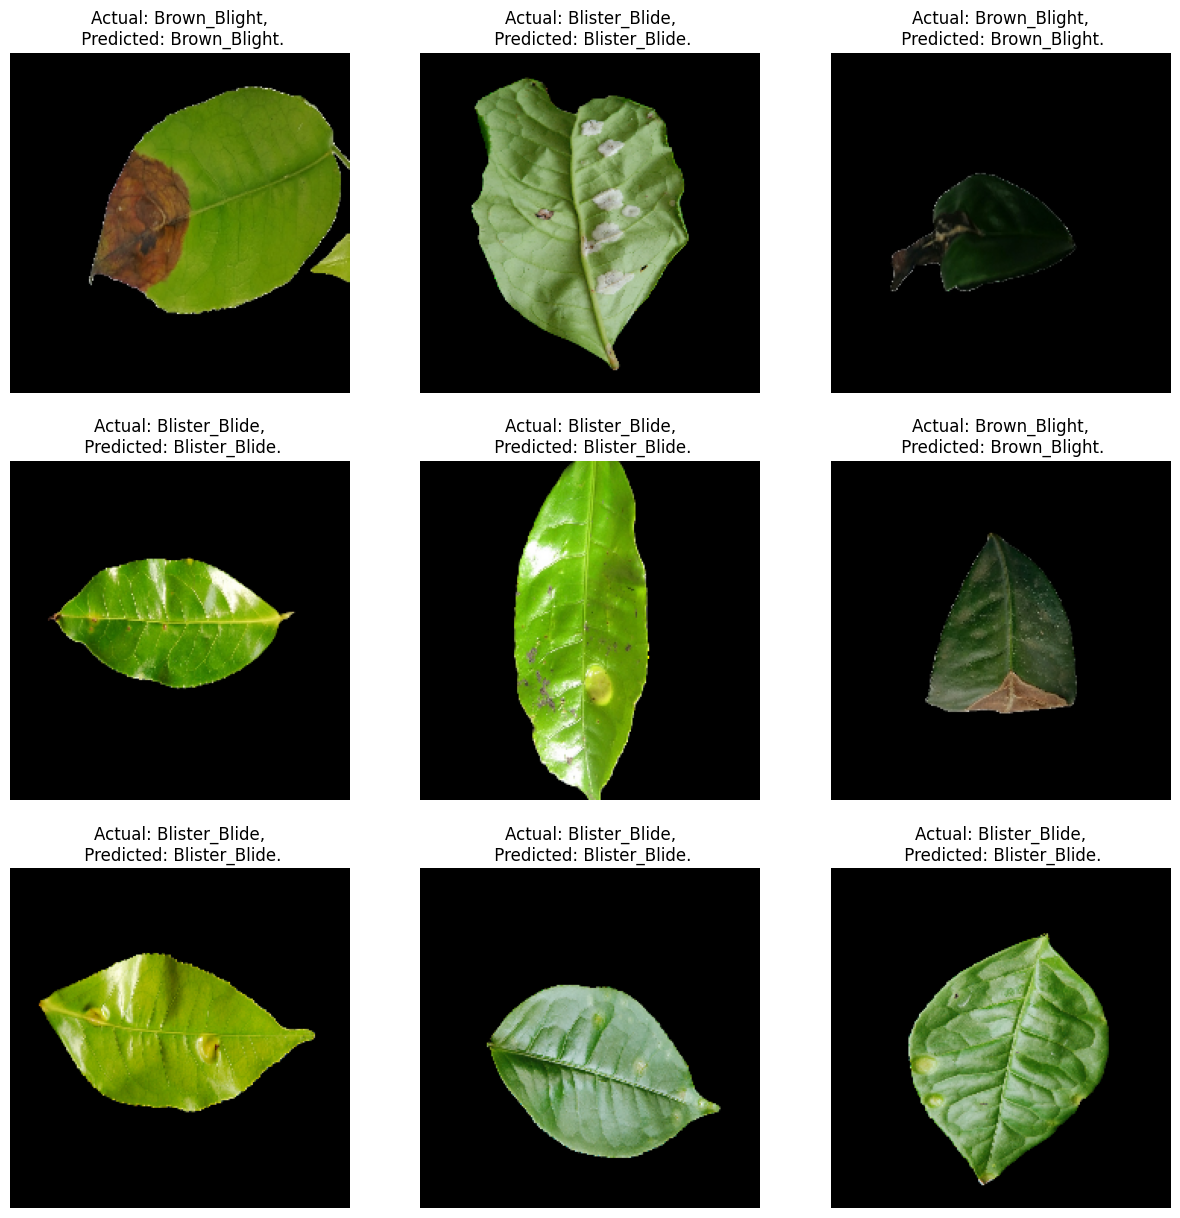

In [32]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in Test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class= predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")
        
        plt.axis("off")

In [33]:
model_version=1
model_name = f'Model_v{model_version}'
model.save(f'./models/{model_name}.h5')